In [1]:
import aes2_added_fb_prize_as_features_preprocessing

CUDA_AVAILABLE = True


2024-07-01 22:33:09.794708: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-01 22:33:09.854746: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 22:33:09.854783: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 22:33:09.856259: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-01 22:33:09.865662: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import gc

gc.collect()

48

In [3]:
import pickle
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"  # 指定使用 GPU
sys.path.append('/home/mcq/GitHub/aes2')
sys.path.append('/home/mcq/GitHub/aes2/topic-classificatio')
import numpy as np
from sklearn.model_selection import GroupKFold
import pandas as pd
import pickle
with open("/home/mcq/GitHub/aes2/train_data/train_feats.pkl", "rb") as f:
    train_feats = pickle.load(f)
with open("/home/mcq/GitHub/aes2/train_data/X.pkl", "rb") as f:
    X = pickle.load(f)
with open("/home/mcq/GitHub/aes2/train_data/y.pkl", "rb") as f:
    y = pickle.load(f)
with open("/home/mcq/GitHub/aes2/train_data/y_split.pkl", "rb") as f:
    y_split = pickle.load(f)
with open(
    "/home/mcq/GitHub/aes2/train_data/feature_select.pkl", "rb"
) as f:
    feature_select = pickle.load(f)
with open(
    "/home/mcq/GitHub/aes2/train_data/base_skf_feat/category-feat.pkl", "rb"
) as f:
    topic = pickle.load(f)
aes2_added_fb_prize_as_features_preprocessing.feature_select = feature_select



In [4]:
train_feats.iloc[:5, -20:]
train_feats_17000_index = (train_feats['essay_id'].str.len() == 7)
train_feats_2 = train_feats[train_feats_17000_index] #筛选原数据集的feats
train_feats_1 = train_feats[~train_feats_17000_index] #筛选额外数据集的feats


In [5]:
with open("/home/mcq/GitHub/aes2/train_data/base_skf_feat/train_feats.pkl", "rb") as f:
    train_feats_OR = pickle.load(f)
with open("/home/mcq/GitHub/aes2/train_data/base_skf_feat/y.pkl", "rb") as f:
    y_OR = pickle.load(f)
with open("/home/mcq/GitHub/aes2/train_data/base_skf_feat/y_split.pkl", "rb") as f:
    y_split_OR = pickle.load(f)

In [6]:
X.shape
# _EX for extra
# _OR for original

X_OR = train_feats_OR[feature_select].astype(np.float32).values
X_EX = X[~train_feats_17000_index]

# y_OR = y[train_feats_17000_index]
y_EX = y[~train_feats_17000_index]

# y_split_OR = y_split[train_feats_17000_index]
y_split_EX = y_split[~train_feats_17000_index]



In [7]:
import numpy as np

def clean_feature_names(features):
    illegal_chars = ['[', ']', '<', '>']
    cleaned_features = []
    for feature in features:
        for char in illegal_chars:
            feature = feature.replace(char, 'lessthan')
        cleaned_features.append(feature)
    return cleaned_features

train_feats.columns = clean_feature_names(train_feats.columns)
feature_select = clean_feature_names(feature_select)
with open("/home/mcq/GitHub/aes2/train_data/train_2.pkl", "rb") as f:
    train_2 = pickle.load(f)

with open("/home/mcq/GitHub/aes2/train_data/GKF_train.pkl", "rb") as f:
    GKF_train = pickle.load(f)

# X = train_feats[feature_select].astype(np.float32).values
# y_split = train_2[feature_select].astype(np.float32).values 

# X_2 = train_feats_1 ##注意这里的X2要更改为GKF_train 的feature select 之后的文件
# #X_2 = train_feats[feature_names].astype(np.float32).values 
# y_split_2 = GKF_train['score'].astype(int).values


In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, cohen_kappa_score
from aes2_added_fb_prize_as_features_preprocessing import *



def find_thresholds(true, pred, steps=50):

    # SAVE TRIALS FOR PLOTTING
    xs = [[],[],[],[],[]]
    ys = [[],[],[],[],[]]

    # COMPUTE BASELINE METRIC
    threshold = [1.5, 2.5, 3.5, 4.5, 5.5]
    pred2 = pd.cut(pred, [-np.inf] + threshold + [np.inf], 
                    labels=[1,2,3,4,5,6]).astype('int32')
    best = cohen_kappa_score(true, pred2, weights="quadratic")

    # FIND FIVE OPTIMAL THRESHOLDS
    for k in range(5):
        for sign in [1,-1]:
            v = threshold[k]
            threshold2 = threshold.copy()
            stop = 0
            while stop<steps:

                # TRY NEW THRESHOLD
                v += sign * 0.01
                threshold2[k] = v
                pred2 = pd.cut(pred, [-np.inf] + threshold2 + [np.inf], 
                                labels=[1,2,3,4,5,6]).astype('int32')
                metric = cohen_kappa_score(true, pred2, weights="quadratic")

                # SAVE TRIALS FOR PLOTTING
                xs[k].append(v)
                ys[k].append(metric)

                # EARLY STOPPING
                if metric<=best:
                    stop += 1
                else:
                    stop = 0
                    best = metric
                    threshold = threshold2.copy()

    # COMPUTE FINAL METRIC
    pred2 = pd.cut(pred, [-np.inf] + threshold + [np.inf], 
                    labels=[1,2,3,4,5,6]).astype('int32')
    best = cohen_kappa_score(true, pred2, weights="quadratic")   

    # RETURN RESULTS
    threshold = [np.round(t,3) for t in threshold]
    return best, threshold, xs, ys

# best, thresholds, xs, ys = find_thresholds(y_split, oof, steps=500)
# print('Best thresholds are:', thresholds )
# print('=> achieve Overall CV QWK score =', best )

# >> Output: thresholds = [1.5, 2.6, 3.5, 4.59, 5.55]
thresholds = [1.51, 2.6, 3.5, 4.59, 5.56]







models = []
predictions = []
f1_scores = []
kappa_scores = []
groups = topic['topic']
tuner_params = {
    "gpu_id" : 2,
    "learning_rate_lgb": 0.05,
    "max_depth_lgb": 8,
    "num_leaves_lgb": 40,
    "colsample_bytree_lgb": 0.3,
    "reg_alpha_lgb": 0.85,
    "reg_lambda_lgb": 0.65,
    "n_estimators_lgb": 700,
    "learning_rate_xgb": 0.1,
    "max_depth_xgb": 8,
    "num_leaves_xgb": 10,
    "colsample_bytree_xgb": 0.5,
    "reg_alpha_xgb": 0.35,
    "reg_lambda_xgb": 0.15,
    "n_estimators_xgb": 1024,
    "n_splits": 7
}

n_splits = tuner_params['n_splits']
oof = np.zeros(len(train), dtype='float32')

class Predictor:
    def __init__(self, models: list):
        self.models = models
#         self.xgb_boost_best_iter = models[1].
    def predict(self, X):
        n_models = len(self.models)
        predicted = None
        # n = 0.709
        n = 0.92
        for i, model in enumerate(self.models):
            if i == 0:
                predicted = n*model.predict(X)
            else:
                # if not isinstance(X, xgb.DMatrix):
                #     X = xgb.DMatrix(X)
                predicted += (1-n)*model.predict(X)
        return predicted

group_kfold = GroupKFold(n_splits=n_splits)
xgboost_best_iters = []
light_best_iters = []
# thresholds = [1.5, 2.5, 3.5, 4.5, 5.5] # init threshold


In [9]:
index = np.where(~train_feats_17000_index)[0]

# Find Threshold

fold 1


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=8) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=256) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.807355	valid's QWK: 0.738954
[50]	train's QWK: 0.861634	valid's QWK: 0.779497
[75]	train's QWK: 0.872982	valid's QWK: 0.787404
[100]	train's QWK: 0.880083	valid's QWK: 0.789697
[125]	train's QWK: 0.885797	valid's QWK: 0.788823
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[150]	train's QWK: 0.890223	valid's QWK: 0.789094
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:52:44] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:52:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight", "extra_trees", "metrics", "num_leaves

[0]	validation_0-rmse:1.11374	validation_0-QWK:0.43985	validation_1-rmse:0.88010	validation_1-QWK:0.46346
[0]	validation_0-rmse:1.11374	validation_0-QWK:0.43985	validation_1-rmse:0.88010	validation_1-QWK:0.46346
[1]	validation_0-rmse:1.00196	validation_0-QWK:0.45240	validation_1-rmse:0.81528	validation_1-QWK:0.48211
[2]	validation_0-rmse:0.89868	validation_0-QWK:0.47604	validation_1-rmse:0.75732	validation_1-QWK:0.50903
[3]	validation_0-rmse:0.80652	validation_0-QWK:0.57638	validation_1-rmse:0.70922	validation_1-QWK:0.53534
[4]	validation_0-rmse:0.72887	validation_0-QWK:0.66289	validation_1-rmse:0.67152	validation_1-QWK:0.57665
[5]	validation_0-rmse:0.66521	validation_0-QWK:0.70059	validation_1-rmse:0.64165	validation_1-QWK:0.60503
[6]	validation_0-rmse:0.61860	validation_0-QWK:0.72491	validation_1-rmse:0.61366	validation_1-QWK:0.62835
[7]	validation_0-rmse:0.57454	validation_0-QWK:0.75497	validation_1-rmse:0.59487	validation_1-QWK:0.66320
[8]	validation_0-rmse:0.53817	validation_0-QWK

/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:53:17] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [22:53:17] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:2, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)



Fold_1 XGBoost Model saved.



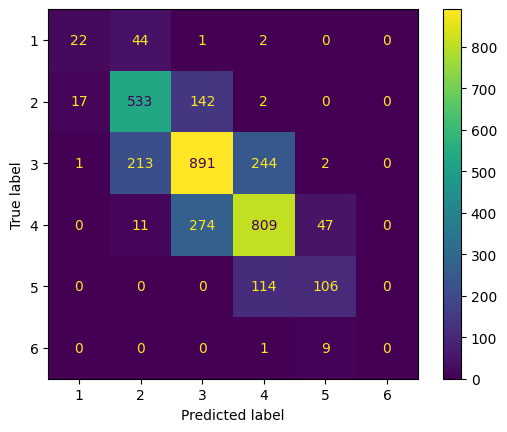

F1 score across fold: 0.6736671133244124
Cohen kappa score across fold: 0.7865291905398925
fold 2
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=8) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=256) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.802819	valid's QWK: 0.797393
[50]	train's QWK: 0.859737	valid's QWK: 0.84269
[75]	train's QWK: 0.871073	valid's QWK: 0.849645
[100]	train's QWK: 0.877077	valid's QWK: 0.853146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[125]	train's QWK: 0.881771	valid's QWK: 0.853385
[150]	train's QWK: 0.886536	valid's QWK: 0.854296
[175]	train's QWK: 0.891066	valid's Q

/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:13:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight", "extra_trees", "metrics", "num_leaves" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:1.08894	validation_0-QWK:0.44754	validation_1-rmse:1.07739	validation_1-QWK:0.43984
[0]	validation_0-rmse:1.08894	validation_0-QWK:0.44754	validation_1-rmse:1.07739	validation_1-QWK:0.43984
[1]	validation_0-rmse:0.98006	validation_0-QWK:0.46365	validation_1-rmse:0.97823	validation_1-QWK:0.46162
[2]	validation_0-rmse:0.88089	validation_0-QWK:0.48254	validation_1-rmse:0.88374	validation_1-QWK:0.49156
[3]	validation_0-rmse:0.79220	validation_0-QWK:0.57265	validation_1-rmse:0.80186	validation_1-QWK:0.53217
[4]	validation_0-rmse:0.71773	validation_0-QWK:0.66340	validation_1-rmse:0.73874	validation_1-QWK:0.62565
[5]	validation_0-rmse:0.65698	validation_0-QWK:0.69664	validation_1-rmse:0.68996	validation_1-QWK:0.66987
[6]	validation_0-rmse:0.61286	validation_0-QWK:0.71978	validation_1-rmse:0.65077	validation_1-QWK:0.70188
[7]	validation_0-rmse:0.57039	validation_0-QWK:0.75375	validation_1-rmse:0.61800	validation_1-QWK:0.74536
[8]	validation_0-rmse:0.53569	validation_0-QWK

/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:14:15] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)



Fold_2 XGBoost Model saved.



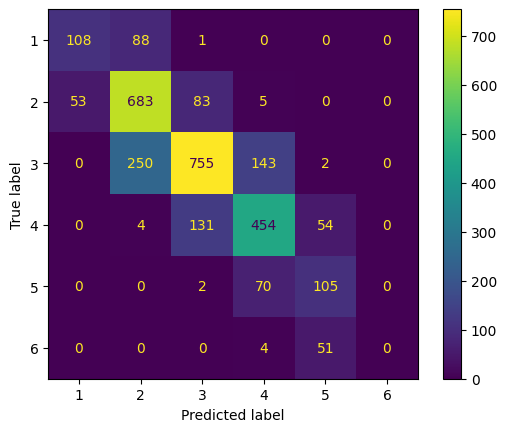

F1 score across fold: 0.6842216123707762
Cohen kappa score across fold: 0.8501938730328606
fold 3
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=8) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=256) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.809952	valid's QWK: 0.767428
[50]	train's QWK: 0.859515	valid's QWK: 0.808962
[75]	train's QWK: 0.870307	valid's QWK: 0.819363
[100]	train's QWK: 0.87771	valid's QWK: 0.822881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[125]	train's QWK: 0.882733	valid's QWK: 0.826457
[150]	train's QWK: 0.887714	valid's QWK: 0.827578
[LightGBM] [Warning] No further split

/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:36:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight", "extra_trees", "metrics", "num_leaves" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:1.07401	validation_0-QWK:0.47142	validation_1-rmse:1.19792	validation_1-QWK:0.40264
[0]	validation_0-rmse:1.07401	validation_0-QWK:0.47142	validation_1-rmse:1.19792	validation_1-QWK:0.40264
[1]	validation_0-rmse:0.96546	validation_0-QWK:0.46938	validation_1-rmse:1.08866	validation_1-QWK:0.40757
[2]	validation_0-rmse:0.86702	validation_0-QWK:0.48907	validation_1-rmse:0.98981	validation_1-QWK:0.41487
[3]	validation_0-rmse:0.77956	validation_0-QWK:0.58422	validation_1-rmse:0.90579	validation_1-QWK:0.48614
[4]	validation_0-rmse:0.70593	validation_0-QWK:0.66698	validation_1-rmse:0.83345	validation_1-QWK:0.60338
[5]	validation_0-rmse:0.64607	validation_0-QWK:0.69624	validation_1-rmse:0.77774	validation_1-QWK:0.65161
[6]	validation_0-rmse:0.60277	validation_0-QWK:0.72086	validation_1-rmse:0.73779	validation_1-QWK:0.68260
[7]	validation_0-rmse:0.56086	validation_0-QWK:0.75932	validation_1-rmse:0.70221	validation_1-QWK:0.71623
[8]	validation_0-rmse:0.52642	validation_0-QWK

/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:37:36] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)



Fold_3 XGBoost Model saved.



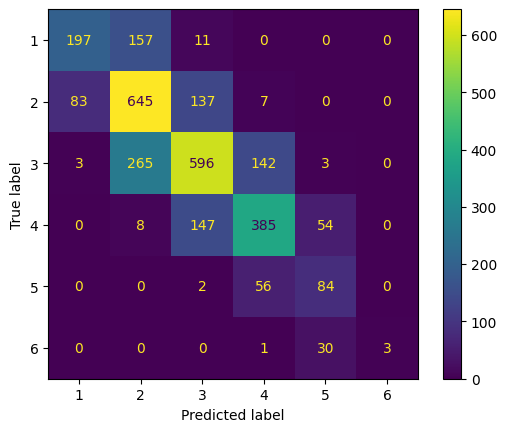

F1 score across fold: 0.629885263001217
Cohen kappa score across fold: 0.8275097254286641
fold 4
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=8) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=256) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.806269	valid's QWK: 0.735443
[50]	train's QWK: 0.859797	valid's QWK: 0.771009
[75]	train's QWK: 0.871255	valid's QWK: 0.782031
[100]	train's QWK: 0.878868	valid's QWK: 0.779735
[125]	train's QWK: 0.884206	valid's QWK: 0.776306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[150]	train's QWK: 0.888614	valid's QWK: 0.774319
Early stopping, best iteration is:
[77]	train's QWK: 0.872033	valid's QWK: 0.782226
Evaluated only: QWK

Fold_4 

/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:52:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight", "extra_trees", "metrics", "num_leaves" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:1.08768	validation_0-QWK:0.45005	validation_1-rmse:1.08314	validation_1-QWK:0.42655
[0]	validation_0-rmse:1.08768	validation_0-QWK:0.45005	validation_1-rmse:1.08314	validation_1-QWK:0.42655
[1]	validation_0-rmse:0.97780	validation_0-QWK:0.46834	validation_1-rmse:0.99054	validation_1-QWK:0.43411
[2]	validation_0-rmse:0.87841	validation_0-QWK:0.48331	validation_1-rmse:0.89835	validation_1-QWK:0.43872
[3]	validation_0-rmse:0.79009	validation_0-QWK:0.58072	validation_1-rmse:0.82393	validation_1-QWK:0.47310
[4]	validation_0-rmse:0.71570	validation_0-QWK:0.67009	validation_1-rmse:0.75997	validation_1-QWK:0.54410
[5]	validation_0-rmse:0.65467	validation_0-QWK:0.70329	validation_1-rmse:0.70917	validation_1-QWK:0.59191
[6]	validation_0-rmse:0.61074	validation_0-QWK:0.72223	validation_1-rmse:0.66674	validation_1-QWK:0.63494
[7]	validation_0-rmse:0.56895	validation_0-QWK:0.75792	validation_1-rmse:0.63483	validation_1-QWK:0.68521
[8]	validation_0-rmse:0.53456	validation_0-QWK

/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:53:00] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)



Fold_4 XGBoost Model saved.



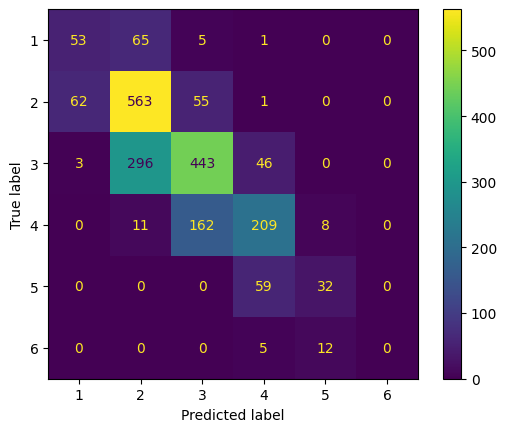

F1 score across fold: 0.6118286554037282
Cohen kappa score across fold: 0.7701003413144456
fold 5
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=8) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=256) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.810519	valid's QWK: 0.776446
[50]	train's QWK: 0.859554	valid's QWK: 0.817992
[75]	train's QWK: 0.8695	valid's QWK: 0.822856
[100]	train's QWK: 0.876185	valid's QWK: 0.826949
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[125]	train's QWK: 0.880828	valid's QWK: 0.827322
[150]	train's QWK: 0.885263	valid's QWK: 0.827484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[175]	train's QWK: 0.889618	valid's QW

/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:21:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight", "extra_trees", "metrics", "num_leaves" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:1.08302	validation_0-QWK:0.45145	validation_1-rmse:1.14223	validation_1-QWK:0.42338
[0]	validation_0-rmse:1.08302	validation_0-QWK:0.45145	validation_1-rmse:1.14223	validation_1-QWK:0.42338
[1]	validation_0-rmse:0.97440	validation_0-QWK:0.46727	validation_1-rmse:1.03706	validation_1-QWK:0.44066
[2]	validation_0-rmse:0.87502	validation_0-QWK:0.48779	validation_1-rmse:0.94577	validation_1-QWK:0.49081
[3]	validation_0-rmse:0.78671	validation_0-QWK:0.57612	validation_1-rmse:0.86935	validation_1-QWK:0.53751
[4]	validation_0-rmse:0.71244	validation_0-QWK:0.66304	validation_1-rmse:0.80760	validation_1-QWK:0.64656
[5]	validation_0-rmse:0.65165	validation_0-QWK:0.69297	validation_1-rmse:0.75917	validation_1-QWK:0.68767
[6]	validation_0-rmse:0.60788	validation_0-QWK:0.71662	validation_1-rmse:0.72955	validation_1-QWK:0.71097
[7]	validation_0-rmse:0.56578	validation_0-QWK:0.75445	validation_1-rmse:0.69816	validation_1-QWK:0.73952
[8]	validation_0-rmse:0.53132	validation_0-QWK

/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:21:54] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)



Fold_5 XGBoost Model saved.



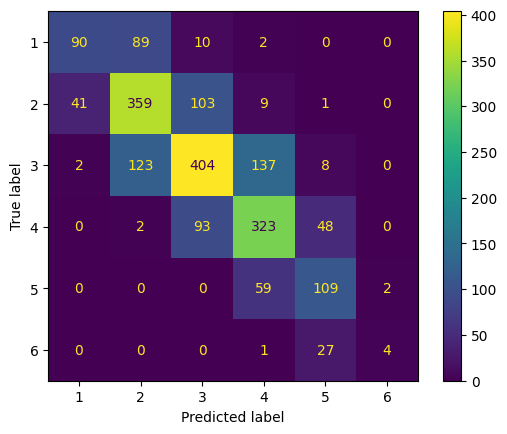

F1 score across fold: 0.6257019844145127
Cohen kappa score across fold: 0.8304443495718543
fold 6
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=8) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=256) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.808474	valid's QWK: 0.750534
[50]	train's QWK: 0.861282	valid's QWK: 0.79039
[75]	train's QWK: 0.871994	valid's QWK: 0.797301
[100]	train's QWK: 0.878735	valid's QWK: 0.800626
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[125]	train's QWK: 0.883756	valid's QWK: 0.801655
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[150]	train'

/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:45:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight", "extra_trees", "metrics", "num_leaves" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:1.09061	validation_0-QWK:0.45452	validation_1-rmse:1.04516	validation_1-QWK:0.42250
[0]	validation_0-rmse:1.09061	validation_0-QWK:0.45452	validation_1-rmse:1.04516	validation_1-QWK:0.42250
[1]	validation_0-rmse:0.98089	validation_0-QWK:0.46521	validation_1-rmse:0.96511	validation_1-QWK:0.43908
[2]	validation_0-rmse:0.88062	validation_0-QWK:0.49156	validation_1-rmse:0.89404	validation_1-QWK:0.44745
[3]	validation_0-rmse:0.79141	validation_0-QWK:0.57966	validation_1-rmse:0.83062	validation_1-QWK:0.48812
[4]	validation_0-rmse:0.71650	validation_0-QWK:0.66274	validation_1-rmse:0.77981	validation_1-QWK:0.59263
[5]	validation_0-rmse:0.65529	validation_0-QWK:0.69500	validation_1-rmse:0.73905	validation_1-QWK:0.64428
[6]	validation_0-rmse:0.61033	validation_0-QWK:0.71938	validation_1-rmse:0.71611	validation_1-QWK:0.66602
[7]	validation_0-rmse:0.56810	validation_0-QWK:0.75498	validation_1-rmse:0.69034	validation_1-QWK:0.69013
[8]	validation_0-rmse:0.53316	validation_0-QWK

/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:46:05] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)



Fold_6 XGBoost Model saved.



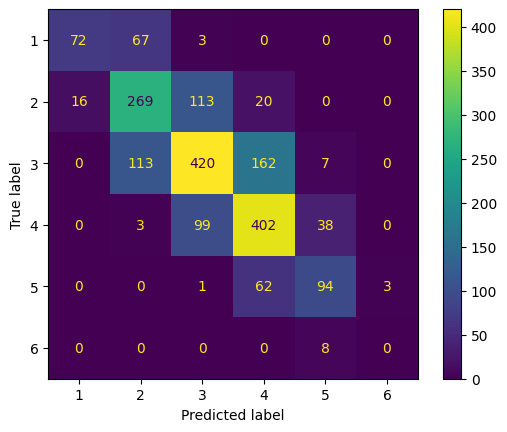

F1 score across fold: 0.6353436763546162
Cohen kappa score across fold: 0.8075426945198207
fold 7
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=8) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=256) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Using self-defined objective function
Training until validation scores don't improve for 75 rounds
[25]	train's QWK: 0.806986	valid's QWK: 0.623599
[50]	train's QWK: 0.859789	valid's QWK: 0.690044
[75]	train's QWK: 0.870834	valid's QWK: 0.698201
[100]	train's QWK: 0.877519	valid's QWK: 0.703482
[125]	train's QWK: 0.882566	valid's QWK: 0.703781
[150]	train's QWK: 0.887471	valid's QWK: 0.707657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[175]	train's QWK: 0.891423	valid's QWK: 0.71328
[LightGBM] [Warning] No further splits with positive gain, bes

/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(
/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [01:14:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight", "extra_trees", "metrics", "num_leaves" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:1.07940	validation_0-QWK:0.46430	validation_1-rmse:1.20811	validation_1-QWK:0.25838
[0]	validation_0-rmse:1.07940	validation_0-QWK:0.46430	validation_1-rmse:1.20811	validation_1-QWK:0.25838
[1]	validation_0-rmse:0.97052	validation_0-QWK:0.46979	validation_1-rmse:1.09782	validation_1-QWK:0.26801
[2]	validation_0-rmse:0.87230	validation_0-QWK:0.49002	validation_1-rmse:0.99013	validation_1-QWK:0.24775
[3]	validation_0-rmse:0.78530	validation_0-QWK:0.58355	validation_1-rmse:0.89677	validation_1-QWK:0.27100
[4]	validation_0-rmse:0.71255	validation_0-QWK:0.66925	validation_1-rmse:0.81834	validation_1-QWK:0.41270
[5]	validation_0-rmse:0.65326	validation_0-QWK:0.70067	validation_1-rmse:0.75364	validation_1-QWK:0.45023
[6]	validation_0-rmse:0.61037	validation_0-QWK:0.72103	validation_1-rmse:0.70466	validation_1-QWK:0.46183
[7]	validation_0-rmse:0.56919	validation_0-QWK:0.75518	validation_1-rmse:0.66019	validation_1-QWK:0.50338
[8]	validation_0-rmse:0.53531	validation_0-QWK

/home/mcq/anaconda3/envs/torch/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [01:14:41] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)



Fold_7 XGBoost Model saved.



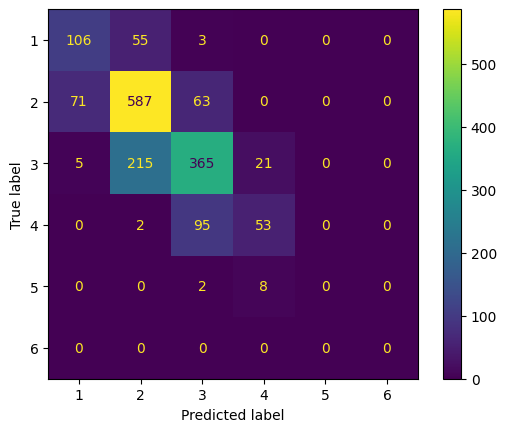

F1 score across fold: 0.663147323891111
Cohen kappa score across fold: 0.7150000089907629


In [10]:
LOAD = True # re-train
if not LOAD:
    for i in range(n_splits):
        random_indices = np.random.choice(X.shape[0], size=5000, replace=False)
        random_test_X = X[random_indices, :]
        random_test_y = y_split[random_indices]
        lgb_predictor = lgb.Booster(model_file=f'/home/mcq/GitHub/aes2/kaggle/out/aes-lgbm/fold_{i+1}.txt')
        # cat_model = CatBoostRegressor()
        # cat_model.load_model(f'kaggle/input/aes-catboost/fold_{i+1}.cbm')
        xgb_regressor = xgb.Booster()
        xgb_regressor.load_model(f'/home/mcq/GitHub/aes2/kaggle/out/aes-xgboost/fold_{i+1}.bin')

        predictor = Predictor([lgb_predictor, xgb_regressor])
        
        models.append(predictor)
        
        # # Make predictions on the test data for this fold
        #         # Make predictions on the test data for this fold
        # predictions_fold = predictor.predict(random_test_X)
        # predictions_fold = predictions_fold + a
        # predictions_fold = predictions_fold.clip(1, 6).round().astype(int)
        
        # # Confusion Matrix for each fold
        # cm = confusion_matrix(random_test_y, predictions_fold, labels=[x for x in range(1,7)])
        # disp = ConfusionMatrixDisplay(confusion_matrix=cm,
        #                               display_labels=[x for x in range(1,7)])
        # disp.plot()
        # plt.show()
        
        # # Calculate and store the F1 score for this fold
        # f1_fold = f1_score(random_test_y, predictions_fold, average='weighted')
        # f1_scores.append(f1_fold)

        # # Calculate and store the Cohen's kappa score for this fold
        # kappa_fold = cohen_kappa_score(random_test_y, predictions_fold, weights='quadratic')
        # kappa_scores.append(kappa_fold)

        # print(f'F1 score across fold: {f1_fold}')
        # print(f'Cohen kappa score across fold: {kappa_fold}')
        gc.collect()
else:
    for i, (train_index, test_index) in enumerate(group_kfold.split(X_OR, y_split_OR,groups), 1):
    # Split the data into training and testing sets for this fold
        print('fold',i)
        # X_train_fold = np.hstack((X[train_index],X_EX))
        # X_test_fold  = X[test_index]
        # y_train_fold = np.hstack((y[train_index],y_EX))
        # y_test_fold = y[test_index]
        # y_test_fold_int = y_split[test_index]
        X_train_fold_1, X_test_fold = X_OR[train_index], X_OR[test_index]
        X_train_fold_2 = X[index]
        X_train_fold = np.vstack((X_train_fold_1, X_train_fold_2))
        ## 链接2个训练集

        y_train_fold_1, y_test_fold, y_test_fold_int = y_OR[train_index], y_OR[test_index], y_split_OR[test_index]
        y_train_fold_2 = y[index]
        y_train_fold = np.hstack((y_train_fold_1, y_train_fold_2))
        callbacks = [log_evaluation(period=25), early_stopping(stopping_rounds=75,first_metric_only=True)]
        light = lgb.LGBMRegressor(
                objective = qwk_obj,
                metrics = 'None',
                learning_rate = tuner_params["learning_rate_lgb"],
                max_depth = tuner_params["max_depth_lgb"],
                num_leaves = tuner_params["num_leaves_lgb"],
                colsample_bytree = tuner_params["colsample_bytree_lgb"],
                reg_alpha = tuner_params["reg_alpha_lgb"],
                reg_lambda = tuner_params["reg_lambda_lgb"],
                n_estimators = tuner_params["n_estimators_lgb"],
                random_state=42,
                extra_trees=True,
                class_weight='balanced',
                # device='gpu' if CUDA_AVAILABLE else 'cpu',
                # device_type="gpu",
                verbosity = - 1
            )

        # Fit the model on the training data for this fold  
        light.fit(
            X_train_fold,
            y_train_fold,
            eval_names=['train', 'valid'],
            eval_set=[(X_train_fold, y_train_fold), (X_test_fold, y_test_fold)],
            eval_metric=quadratic_weighted_kappa,
            callbacks=callbacks
        )
        light_best_iters.append(light.best_iteration_)
        
        
        light.booster_.save_model(f'kaggle/out/aes-lgbm/fold_{i}.txt')
        print('\nFold_{} LightGBM Model saved.\n'.format(i))
        
        
        xgb_callbacks = [
            xgb.callback.EvaluationMonitor(period=25),
            xgb.callback.EarlyStopping(75, metric_name="QWK", maximize=True, save_best=True)
        ]
        xgb_regressor = xgb.XGBRegressor(
            objective = qwk_obj,
            metrics = 'None',
            learning_rate = tuner_params["learning_rate_xgb"],
            max_depth = tuner_params["max_depth_xgb"],
            num_leaves = tuner_params["num_leaves_xgb"],
            colsample_bytree = tuner_params["colsample_bytree_xgb"],
            reg_alpha = tuner_params["reg_alpha_xgb"],
            reg_lambda = tuner_params["reg_lambda_xgb"],
            n_estimators = tuner_params["n_estimators_xgb"],
            random_state=42,
            extra_trees=True,
            # scale_pos_weight=100,
            class_weight='balanced',
            tree_method="hist",
            # device="gpu" if CUDA_AVAILABLE else "cpu",
            gpu_id = tuner_params["gpu_id"]
        #             device='gpu',
        #             verbosity = 1
        )
        
        xgb_callbacks = [
            xgb.callback.EvaluationMonitor(period=25),
            xgb.callback.EarlyStopping(75, metric_name="QWK", maximize=True, save_best=True)
        ]
        xgb_regressor.fit(
            X_train_fold,
            y_train_fold,
            eval_set=[(X_train_fold, y_train_fold), (X_test_fold, y_test_fold)],
            eval_metric=quadratic_weighted_kappa,
            callbacks=xgb_callbacks
        )
        xgboost_best_iters.append(xgb_regressor.get_booster().best_iteration)
        
        xgb_regressor.save_model(f'kaggle/out/aes-xgboost/fold_{i}.bin')
        print('\nFold_{} XGBoost Model saved.\n'.format(i)) 
        
        predictor = Predictor([light, xgb_regressor])
        
        models.append(predictor)
        # Make predictions on the test data for this fold
        predictions_fold = predictor.predict(X_test_fold)
        predictions_fold = predictions_fold + a
        
        
        predictions_fold = pd.cut(
            predictions_fold, [-np.inf] + thresholds + [np.inf], 
            labels=[1,2,3,4,5,6]
            ).astype('int32')
        # oof[test_index] = predictions_fold
        
        predictions_fold = predictions_fold.clip(1, 6).round()
        predictions.append(predictions_fold)
        # Calculate and store the F1 score for this fold
        f1_fold = f1_score(y_test_fold_int, predictions_fold, average='weighted')
        f1_scores.append(f1_fold)

        # Calculate and store the Cohen's kappa score for this fold
        kappa_fold = cohen_kappa_score(y_test_fold_int, predictions_fold, weights='quadratic')
        kappa_scores.append(kappa_fold)
    #         predictor.booster_.save_model(f'fold_{i}.txt')
        cm = confusion_matrix(y_test_fold_int, predictions_fold, labels=[x for x in range(1,7)])

        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=[x for x in range(1,7)]
        )
        disp.plot()
        plt.show()
        print(f'F1 score across fold: {f1_fold}')
        print(f'Cohen kappa score across fold: {kappa_fold}')

        gc.collect()
        #if ENABLE_DONT_WASTE_YOUR_RUN_TIME:
        #    break


In [11]:
mean_f1_score = np.mean(f1_scores)
mean_kappa_score = np.mean(kappa_scores)
# Print the mean scores
print(f'Mean F1 score across {n_splits} folds: {mean_f1_score}')
print(f'Mean Cohen kappa score across {n_splits} folds: {mean_kappa_score}')
# print(f"XGBoost mean best iters: {sum(xgboost_best_iters)/len(xgboost_best_iters)}")
# print(f"LightBoost mean best iters: {sum(light_best_iters)/len(light_best_iters)}")

Mean F1 score across 7 folds: 0.6462565183943392
Mean Cohen kappa score across 7 folds: 0.7981885976283286


In [12]:

# from aes2_added_fb_prize_as_features_preprocessing import preprocess_test, infer
import aes2_added_fb_prize_as_features_preprocessing

test_feats = aes2_added_fb_prize_as_features_preprocessing.preprocess_test()
aes2_added_fb_prize_as_features_preprocessing.feature_select = feature_select
test_feats = test_feats[feature_select]

test_feats.columns = clean_feature_names(test_feats.columns)
aes2_added_fb_prize_as_features_preprocessing.infer(test_feats, models)


tokenizers.__version__: 0.19.1
transformers.__version__: 4.41.1


Map:   0%|          | 0/3 [00:00<?, ? examples/s]

tokenizers.__version__: 0.19.1
transformers.__version__: 4.41.1


Model: microsoft/deberta-v3-base Score: 0.4590  Scores: [0.4927071121286561, 0.44975919653806296, 0.41900989606208666, 0.46100316932040336, 0.47875430698135113, 0.4529461925915486]


0    000d118
1    000fe60
2    001ab80
Name: text_id, dtype: object
0    000d118
1    000fe60
2    001ab80
Name: text_id, dtype: object
CustomModel(
  (model): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_featur

  0%|          | 0/1 [00:02<?, ?it/s]

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/mcq/anaconda3/envs/torch/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/home/mcq/anaconda3/envs/torch/lib/python3.10/multiprocessing/connection.py", line 177, in close
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/mcq/anaconda3/envs/torch/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/mcq/anaconda3/envs/torch/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    self._close()
  File "/home/mcq/anaconda3/envs/torch/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    reader_close()
  File "/home/mcq/anaconda3/envs/torch/lib/python3.10/multiprocessing/connection.py", line 177, in close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Features number:  21913
[2. 3. 4.]


,essay_id,score
0,000d118,2
1,000fe60,3
2,001ab80,4


In [13]:
# test_columns = set(test_feats.columns)
# train_columns = set(train_feats.columns)
# feature_select_columns = set(feature_select)
# test_unique_columns = test_columns - train_columns
# train_unique_columns = train_columns - test_columns
# feature_select_unique = feature_select_columns - test_columns
# print("Columns only in test_feats:", test_unique_columns)
# print("Columns only in train_feats:", train_unique_columns)
# print(len(train_unique_columns))
# print(len(feature_select_unique))


In [14]:
# train_feats = train_feats.drop(columns=list(train_unique_columns))


In [15]:
# with open("/home/mcq/GitHub/aes2/train_data/train_feats.pkl", "wb") as f:
#     pickle.dump(train_feats, f)